In [8]:
# Google Drive'ı mount edin (eğer henüz etmediyseniz)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Dosyayı depo klasörüne kopyalayın
!cp "/content/drive/MyDrive/Colab Notebooks/Sondetection.ipynb" /content/BERT-Emotion-Lyrics/

# Depo klasörüne gidin
%cd /content/BERT-Emotion-Lyrics

# Git işlemleri yapın
!git add emotion_detection.ipynb
!git commit -m "Add emotion_detection notebook"

# GitHub'a push edin (authentication gerekebilir)
!git push

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/emotion_detection.ipynb': No such file or directory
/content/BERT-Emotion-Lyrics
fatal: pathspec 'emotion_detection.ipynb' did not match any files
On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec refs/heads/main does not match any
error: failed to push some refs to 'https://github.com/gizemtunel/BERT-Emotion-Lyrics.git'


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving lyrics.csv to lyrics.csv


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from google.colab import files
import os

uploaded = files.upload()

df = pd.read_csv("birlesik_sarkilar.csv", encoding="utf-8-sig").dropna()
X = df["lyrics"].tolist()
y = df["mood"].tolist()


le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_labels = len(le.classes_)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = LyricsDataset(X_train, y_train, tokenizer)
test_dataset = LyricsDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-cased", num_labels=num_labels)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5

model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")


model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


print("Accuracy:", accuracy_score(true_labels, preds))
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=le.classes_))


Saving birlesik_sarkilar.csv to birlesik_sarkilar (3).csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Loss: 143.8957
Epoch 2 - Loss: 33.9146
Epoch 3 - Loss: 20.2017
Epoch 4 - Loss: 12.5992
Epoch 5 - Loss: 7.4661
Accuracy: 0.9098196392785571
Classification Report:
              precision    recall  f1-score   support

    mutluluk       0.89      0.94      0.91       100
       sevgi       0.85      0.92      0.88        86
   yalnızlık       0.97      0.95      0.96       101
        öfke       0.95      0.80      0.87       123
      üzüntü       0.89      0.98      0.93        89

    accuracy                           0.91       499
   macro avg       0.91      0.92      0.91       499
weighted avg       0.91      0.91      0.91       499



In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from google.colab import files

uploaded = files.upload()

df = pd.read_csv("birlesik_sarkilar.csv", encoding="utf-8-sig").dropna()
X = df["lyrics"].tolist()
y = df["mood"].tolist()

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_labels = len(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = LyricsDataset(X_train, y_train, tokenizer)
test_dataset = LyricsDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5

model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(true_labels, preds))
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=le.classes_))


Saving birlesik_sarkilar.csv to birlesik_sarkilar.csv


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Loss: 133.1202
Epoch 2 - Loss: 38.6736
Epoch 3 - Loss: 16.4295
Epoch 4 - Loss: 7.7700
Epoch 5 - Loss: 3.8238
Accuracy: 0.9458917835671342
Classification Report:
              precision    recall  f1-score   support

    mutluluk       0.96      0.96      0.96       100
       sevgi       0.89      0.94      0.92        86
   yalnızlık       1.00      0.95      0.97       101
        öfke       0.91      0.91      0.91       123
      üzüntü       0.98      0.98      0.98        89

    accuracy                           0.95       499
   macro avg       0.95      0.95      0.95       499
weighted avg       0.95      0.95      0.95       499



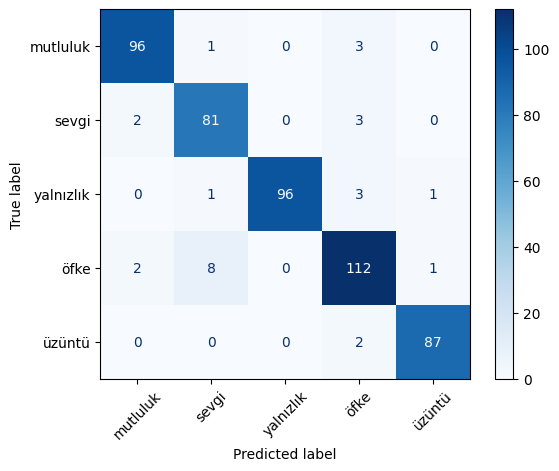

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

